<a href="https://colab.research.google.com/github/AgastyaPatel/cits4012-group/blob/main/CITS4012_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("all")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       tagg

# Project Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Add the folder as shortcut to your drive.  
SourceFolder = "https://drive.google.com/drive/folders/1b3YNNtStoUhGI2F-VUf6RLp1lsoD2Mz_?usp=share_link".   
Then update the sourceFolder variable

In [3]:
import os
os.environ["sourceFolder"] = "/content/drive/MyDrive/NLP Group Assignment (Group 18)"

In [4]:
from pathlib import Path
import os

# Replace the folder with the path
sourceFolder = Path(os.environ.get("sourceFolder"))
Files_Required = ["train.json", "test.json", "validation.json",
                  "train_formatted.json", "test_formatted.json", "validation_formatted.json"]
if os.path.exists(sourceFolder):
  pass
else:
  raise FileNotFoundError("Source Folder could not be found. please check mounting of the drive")

for file in Files_Required:
    file_path = sourceFolder/file
    if os.path.exists(file_path):
        print(f"Found {file_path}")
    else:
        raise FileNotFoundError(f"File {file} could not be found. please check mounting of the drive")

Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/train.json
Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/test.json
Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/validation.json
Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/train_formatted.json
Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/test_formatted.json
Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/validation_formatted.json


In [5]:
train_formatted_file = sourceFolder/"train_formatted.json"
test_formatted_file = sourceFolder/"test_formatted.json"
validation_formatted_file = sourceFolder/"validation_formatted.json"

Downloading the gloveTokenizer to the drive. You don't have to redownload it. Skip the next cell

In [6]:
glove_dir = Path(sourceFolder) / "glove"
zip_path = Path(sourceFolder) / "glove.6B.zip"

# Check if GloVe folder exists
if glove_dir.exists():
    print(f"GloVe folder already exists at: {glove_dir}")
else:
    print("GloVe not found. Downloading and extracting...")

    # Download zip only if missing
    if not zip_path.exists():
        !wget http://nlp.stanford.edu/data/glove.6B.zip -O "{zip_path}"

    # Extract to target folder
    !unzip -q "{zip_path}" -d "{glove_dir}"

    print(f"Extraction complete. Files available at: {glove_dir}")

GloVe folder already exists at: /content/drive/MyDrive/NLP Group Assignment (Group 18)/glove


In [7]:
# Check if the glove tokenizer is present in the sourceFolder
file_path = sourceFolder/"glove.6B.zip"
if os.path.exists(file_path):
    print(f"Found {file_path}")
else:
    raise FileNotFoundError(f"Tokenizer Glove couldn't be found in the source directory. Please go and run the wget cell again with your drive mounted folder")


Found /content/drive/MyDrive/NLP Group Assignment (Group 18)/glove.6B.zip


In [35]:
os.makedirs(sourceFolder/"data", exist_ok=True)
os.makedirs(sourceFolder/"utils", exist_ok=True)
os.makedirs(sourceFolder/"models", exist_ok=True)
os.makedirs(sourceFolder/"results", exist_ok=True)

# Dataset Description and Preprocessing.
The provided NLI dataset consists of premise–hypothesis–label triplets sourced from science exam questions.

After removing duplicates and null entries, we obtained N = X training samples, Y validation samples, and Z test samples.

Texts were normalised (lowercased, punctuation removed) and tokenised using NLTK. Each token was lemmatised via WordNetLemmatizer.

The final vocabulary contained V = {len(vocab)} unique tokens, with sentence lengths averaging A ± B tokens (see Figure 1). Class distribution was approximately balanced (Figure 2).

Train sample:
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  

Tokenised example:
                                      premise_tokens  \
0  [pluto, rotates, once, on, it, axis, every, 63...   

                                   hypothesis_tokens  
0  [earth, rotates, on, it, axis, once, time, in,...  

Vocabulary size: 2011

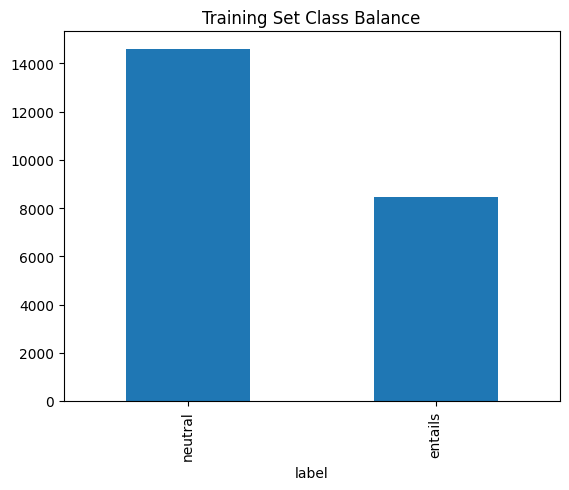

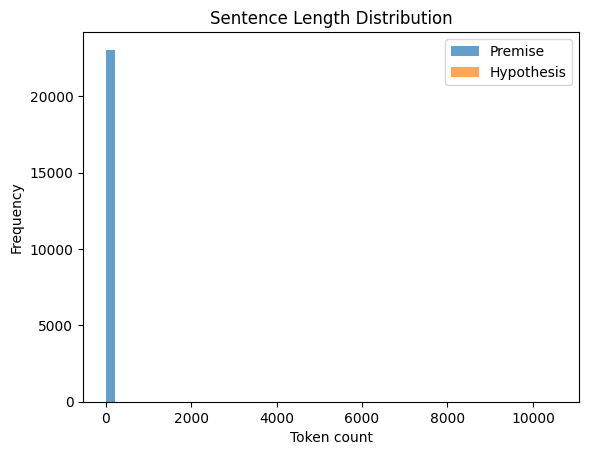

Average premise length: 18.01
Average hypothesis length: 11.74


In [9]:
from itertools import chain

# Step 1: Load datasets
def load_json_to_df(path):
    with open(path, "r") as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_json_to_df(train_formatted_file)
val_df = load_json_to_df(validation_formatted_file)
test_df = load_json_to_df(test_formatted_file)

print("Train sample:")
print(train_df.head())

# Step 2: Clean and normalise text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

for df in [train_df, val_df, test_df]:
    df.dropna(subset=["premise", "hypothesis", "label"], inplace=True)
    df.drop_duplicates(inplace=True)
    df["premise"] = df["premise"].apply(normalize_text)
    df["hypothesis"] = df["hypothesis"].apply(normalize_text)

# Step 3: Tokenise and lemmatise
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text, language='english')
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

for df in [train_df, val_df, test_df]:
    df["premise_tokens"] = df["premise"].apply(tokenize_and_lemmatize)
    df["hypothesis_tokens"] = df["hypothesis"].apply(tokenize_and_lemmatize)

print("\nTokenised example:")
print(train_df[["premise_tokens", "hypothesis_tokens"]].head(1))

#  Step 4: Encode labels
label_map = {"entails": 1, "neutral": 0}
for df in [train_df, val_df, test_df]:
    df["label_id"] = df["label"].map(label_map)

# Step 5: Vocabulary construction
all_tokens = list(chain.from_iterable(train_df["premise_tokens"])) + \
             list(chain.from_iterable(train_df["hypothesis_tokens"]))
vocab = sorted(set(all_tokens))
print(f"\nVocabulary size: {len(vocab)}")

# Build word→index mapping
word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # +1 reserve 0 for padding
idx2word = {idx: word for word, idx in word2idx.items()}

# Step 6: Exploratory analysis
label_counts = train_df["label"].value_counts()
print("\nClass distribution (train):")
print(label_counts)

label_counts.plot(kind="bar", title="Training Set Class Balance")
plt.show()

premise_lens = train_df["premise_tokens"].apply(len)
hypothesis_lens = train_df["hypothesis_tokens"].apply(len)

plt.hist(premise_lens, bins=50, alpha=0.7, label="Premise")
plt.hist(hypothesis_lens, bins=50, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

print(f"Average premise length: {premise_lens.mean():.2f}")
print(f"Average hypothesis length: {hypothesis_lens.mean():.2f}")


In [10]:
processed_files = ["train_preprocessed.csv", "val_preprocessed.csv", "test_preprocessed.csv"]

all_exist = all((sourceFolder /"data"/f).exists() for f in processed_files)
if all_exist:
  print("All processed files already exist. Using existing data.")
else:
  # Step 7: Save processed files
  train_df.to_csv(sourceFolder/"data/train_preprocessed.csv", index=False)
  val_df.to_csv(sourceFolder/"data/val_preprocessed.csv", index=False)
  test_df.to_csv(sourceFolder/"data/test_preprocessed.csv", index=False)
  print(f"\n Preprocessing complete. Cleaned datasets saved to {sourceFolder}/data/")

All processed files already exist. Using existing data.


# Creating Dataset

In [11]:
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Step 1: Build vocabulary from training data

all_tokens = [tok for toks in train_df["premise_tokens"] for tok in toks] + \
             [tok for toks in train_df["hypothesis_tokens"] for tok in toks]

vocab = {"<pad>": 0, "<unk>": 1}
for tok in all_tokens:
    if tok not in vocab:
        vocab[tok] = len(vocab)

inv_vocab = {i: w for w, i in vocab.items()}
print(f" Vocabulary built. Size: {len(vocab)}")

# Step 2: Token → Index conversion function
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

train_df["premise_ids"] = train_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
train_df["hypothesis_ids"] = train_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["premise_ids"] = val_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["hypothesis_ids"] = val_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["premise_ids"] = test_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["hypothesis_ids"] = test_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))

print("Sample encoded example:")
print(train_df[["premise_ids", "hypothesis_ids"]].head(1))

# Step 3: Custom Dataset class for PyTorch
class NLIDataset(Dataset):
    def __init__(self, dataframe):
        self.premises = dataframe["premise_ids"].tolist()
        self.hypotheses = dataframe["hypothesis_ids"].tolist()
        self.labels = dataframe["label_id"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        premise = torch.tensor(self.premises[idx], dtype=torch.long)
        hypothesis = torch.tensor(self.hypotheses[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return premise, hypothesis, label

# Step 4: Collate function for dynamic padding
def collate_fn(batch):
    premises, hypotheses, labels = zip(*batch)
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=vocab["<pad>"])
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.stack(labels)
    return premises_padded, hypotheses_padded, labels

# Step 5: Create DataLoaders
BATCH_SIZE = 32

train_dataset = NLIDataset(train_df)
val_dataset = NLIDataset(val_df)
test_dataset = NLIDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"DataLoaders ready. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Step 6 (Optional): Quick sanity check
prem_batch, hyp_batch, lbl_batch = next(iter(train_loader))
print(f"\nPremise batch shape: {prem_batch.shape}")
print(f"Hypothesis batch shape: {hyp_batch.shape}")
print(f"Label batch shape: {lbl_batch.shape}")


 Vocabulary built. Size: 20118
Sample encoded example:
                        premise_ids                       hypothesis_ids
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  [10, 3, 5, 6, 7, 4, 47, 75, 57, 11]
DataLoaders ready. Train batches: 721, Val batches: 41

Premise batch shape: torch.Size([32, 46])
Hypothesis batch shape: torch.Size([32, 19])
Label batch shape: torch.Size([32])


- We are creating vocabulary for the words present in the hypothesis and premise.
- Each sentence gets converted into list of ids instead of words
- Creating a custom dataset class `NLIDataset` which tells pytorch how to read the one sample at one time
  - Premise -> list of token IDs
  - Hypothese -> list of token IDs
  - label -> integer label (0 or 1) based on the label_map
- `encode_tokens` is used to convert the list of words into list of work indexes
- Handle different sentence lengths by using padding.
  - collate_fn pads all sentences in a batch to the same length, it fills empty word spot with `<pad>` which has the id 0

- Create DataLoader
  - Batches data with 32 samples at a time
  - shuffles and uses collate_fn to each batch

In [12]:
# Sanity check to show one batch
prem_batch, hyp_batch, lbl_batch = next(iter(train_loader))
print(f"\nPremise batch shape: {prem_batch.shape}")
print(f"Hypothesis batch shape: {hyp_batch.shape}")
print(f"Label batch shape: {lbl_batch.shape}")
print(prem_batch[0])
print(hyp_batch[0])
print(lbl_batch[0])


Premise batch shape: torch.Size([32, 32])
Hypothesis batch shape: torch.Size([32, 36])
Label batch shape: torch.Size([32])
tensor([7416,  968, 4193,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor([7416,  968,   45,   14,  968,   63,  970, 7416, 7450,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor(0)


In [13]:
# Encode tokens and labels
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

for df in [train_df, val_df, test_df]:
    df["premise_ids"] = df["premise_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["hypothesis_ids"] = df["hypothesis_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["label_id"] = df["label"].map(label_map)   # keep consistent mapping

#  Save vocab and labels
import json, os
os.makedirs("utils", exist_ok=True)

with open(sourceFolder/"utils/vocab.json", "w") as f:
    json.dump(vocab, f)
with open(sourceFolder/"utils/labels.json", "w") as f:
    json.dump(label_map, f)

print(" Saved vocab and label maps to utils/")


#  Sanity check
prem, hyp, lbl = next(iter(train_loader))
print(f"Premise batch: {prem.shape}, Hypothesis batch: {hyp.shape}, Labels: {lbl.shape}")


 Saved vocab and label maps to utils/
Premise batch: torch.Size([32, 31]), Hypothesis batch: torch.Size([32, 23]), Labels: torch.Size([32])


Printing label map again

In [14]:
label_map

{'entails': 1, 'neutral': 0}

## Model Preparation


In [15]:
import torch, torch.nn as nn, torch.nn.functional as F
import math

In [16]:
import torch, random, numpy as np

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Model 1: BiLSTM

## Setting up the embeddings

In [17]:
import numpy as np
import torch.nn as nn

EMB_DIM = 100  # 50, 100, or 300 depending on GloVe file used
GLOVE_PATH = sourceFolder/"glove/glove.6B.100d.txt"


# 1. Load glove vectors
glove_vectors = {}
with open(GLOVE_PATH, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vector

print(f"Loaded {len(glove_vectors):,} GloVe word vectors.")

# 2. Build embedding matrix for modifed vocab
embedding_matrix = np.zeros((len(vocab), EMB_DIM), dtype=np.float32)

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

embedding_matrix = torch.tensor(embedding_matrix)
print(f" Embedding matrix shape: {embedding_matrix.shape}")


Loaded 400,000 GloVe word vectors.
 Embedding matrix shape: torch.Size([20118, 100])


In [18]:
embedding_layer = nn.Embedding.from_pretrained(
    embedding_matrix,
    freeze=False,            # False = fine-tune embeddings during training
    padding_idx=vocab["<pad>"]
)

print("Embedding layer ready.")


Embedding layer ready.


In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

criterion = nn.CrossEntropyLoss()
def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()

Using device: cuda


In [20]:
for name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    print(name, "labels:", df["label_id"].unique())


train labels: [0 1]
val labels: [0 1]
test labels: [0 1]


In [21]:

# BiLSTM Baseline Model (Model 1)

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import zipfile
import os

# Step 1: Model Definition
class BiLSTMBase(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes, pad_idx, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()

        # Pretrained embedding layer (GloVe)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=pad_idx
        )

        self.bilstm = nn.LSTM(embed_dim, hidden_dim,
                              batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)   # variable-length seq → fixed vector
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def encode(self, x):
        emb = self.embedding(x)               # (B, L, E)
        out, _ = self.bilstm(emb)             # (B, L, 2H)
        out = out.permute(0, 2, 1)            # (B, 2H, L)
        pooled = self.pool(out).squeeze(-1)   # (B, 2H)
        return self.dropout(pooled)

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        logits = self.fc(combined)
        return logits


In [22]:
#  Step 2: Initialise Model
vocab_size = len(vocab)
hidden_dim = 128
num_classes = 2
pad_idx = vocab["<pad>"]

model = BiLSTMBase(embedding_matrix, hidden_dim, num_classes, pad_idx).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 5

In [23]:
# For logging
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Step 3: Training + Validation Loop
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for premises, hypotheses, labels in loop:
        premises, hypotheses, labels = premises.to(DEVICE), hypotheses.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(premises, hypotheses)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        train_loss += loss.item() * labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        loop.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for premises, hypotheses, labels in val_loader:
            premises, hypotheses, labels = premises.to(DEVICE), hypotheses.to(DEVICE), labels.to(DEVICE)
            logits = model(premises, hypotheses)
            loss = criterion(logits, labels)
            preds = torch.argmax(logits, dim=1)

            val_loss += loss.item() * labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss/train_total:.4f}, Train Acc={train_correct/train_total:.4f}, "
          f"Val Loss={val_loss/val_total:.4f}, Val Acc={val_correct/val_total:.4f}")
train_losses.append(train_loss / train_total)
train_accs.append(train_correct / train_total)
val_losses.append(val_loss / val_total)
val_accs.append(val_correct / val_total)

Epoch 1/5: 100%|██████████| 721/721 [00:07<00:00, 94.51it/s, acc=0.765, loss=0.478] 


Epoch 1: Train Loss=0.4780, Train Acc=0.7647, Val Loss=0.6921, Val Acc=0.6449


Epoch 2/5: 100%|██████████| 721/721 [00:07<00:00, 99.79it/s, acc=0.867, loss=0.311] 


Epoch 2: Train Loss=0.3106, Train Acc=0.8673, Val Loss=0.7694, Val Acc=0.6825


Epoch 3/5: 100%|██████████| 721/721 [00:06<00:00, 106.60it/s, acc=0.907, loss=0.229]


Epoch 3: Train Loss=0.2287, Train Acc=0.9072, Val Loss=0.6388, Val Acc=0.7416


Epoch 4/5: 100%|██████████| 721/721 [00:07<00:00, 102.53it/s, acc=0.935, loss=0.165]


Epoch 4: Train Loss=0.1646, Train Acc=0.9354, Val Loss=0.8197, Val Acc=0.7232


Epoch 5/5: 100%|██████████| 721/721 [00:06<00:00, 107.12it/s, acc=0.951, loss=0.124]


Epoch 5: Train Loss=0.1245, Train Acc=0.9512, Val Loss=0.7146, Val Acc=0.7592


In [27]:
# Step 4: Save Model Weights
model_path = sourceFolder/"models/bilstm_baseline.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Step 5: Create Zip for Download
zip_path = sourceFolder/"models/bilstm_baseline.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path, arcname=os.path.basename(model_path))

print(f" Model zipped and ready for download: {zip_path}")

#Step 6: Make Downloadable (Colab)
from google.colab import files
files.download(zip_path)

Model saved to /content/drive/MyDrive/NLP Group Assignment (Group 18)/models/bilstm_baseline.pt
 Model zipped and ready for download: /content/drive/MyDrive/NLP Group Assignment (Group 18)/models/bilstm_baseline.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualisation

### Model Evaluation

In [28]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluation helper
def evaluate_model(model, loader, device):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for premises, hypotheses, labels in loader:
            premises, hypotheses, labels = premises.to(device), hypotheses.to(device), labels.to(device)
            logits = model(premises, hypotheses)
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return preds, labels_all

# Validation metrics
val_preds, val_labels = evaluate_model(model, val_loader, DEVICE)
print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["neutral", "entails"]))

# Test metrics
test_preds, test_labels = evaluate_model(model, test_loader, DEVICE)
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["neutral", "entails"]))


Validation Classification Report:
              precision    recall  f1-score   support

     neutral       0.88      0.59      0.71       647
     entails       0.70      0.92      0.79       657

    accuracy                           0.76      1304
   macro avg       0.79      0.76      0.75      1304
weighted avg       0.79      0.76      0.75      1304

Test Classification Report:
              precision    recall  f1-score   support

     neutral       0.86      0.61      0.72      1284
     entails       0.59      0.84      0.69       842

    accuracy                           0.71      2126
   macro avg       0.72      0.73      0.71      2126
weighted avg       0.75      0.71      0.71      2126



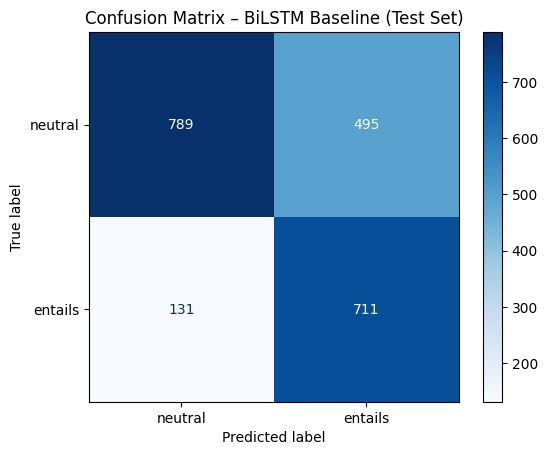

In [29]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral", "entails"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – BiLSTM Baseline (Test Set)")
plt.show()


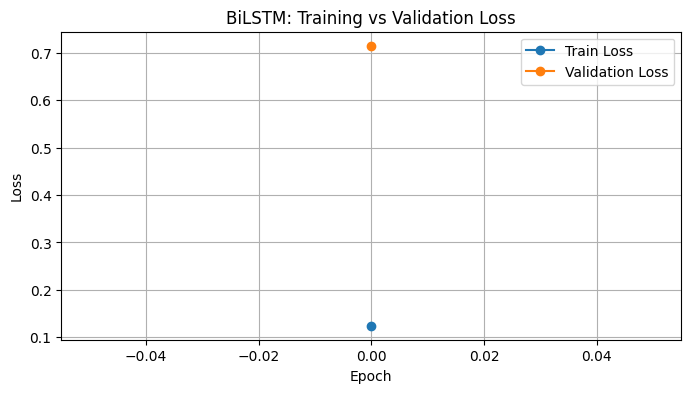

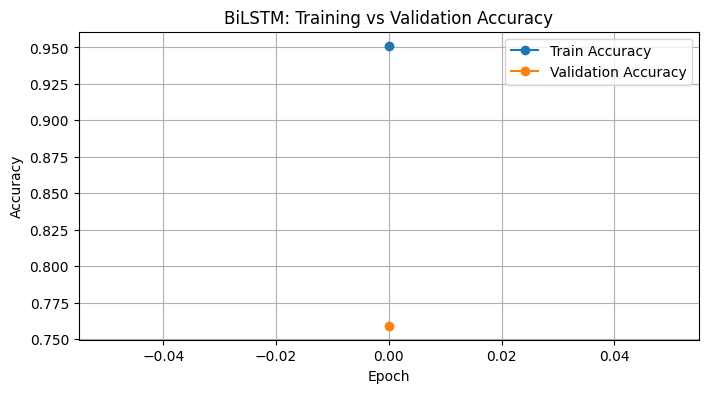

In [30]:
# --- Plot Loss Curves ---
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.legend()
plt.title("BiLSTM: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Plot Accuracy Curves ---
plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Accuracy", marker='o')
plt.plot(val_accs, label="Validation Accuracy", marker='o')
plt.legend()
plt.title("BiLSTM: Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



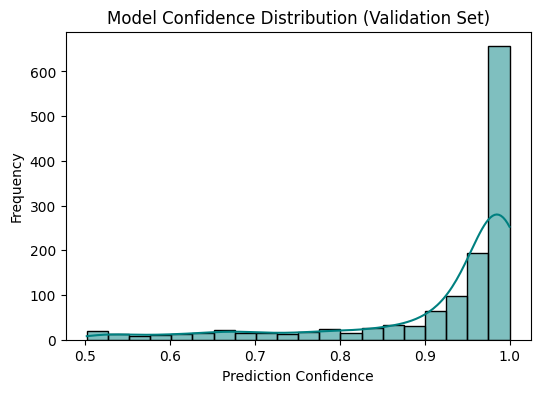

In [33]:
import torch.nn.functional as F
import seaborn as sns

# Collect model confidences on validation set
model.eval()
confidences = []
with torch.no_grad():
    for premises, hypotheses, labels in val_loader:
        premises, hypotheses = premises.to(DEVICE), hypotheses.to(DEVICE)
        logits = model(premises, hypotheses)
        probs = F.softmax(logits, dim=1)
        confidences.extend(probs.max(dim=1)[0].cpu().numpy())

plt.figure(figsize=(6,4))
sns.histplot(confidences, bins=20, kde=True, color="teal")
plt.title("Model Confidence Distribution (Validation Set)")
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.show()


In [36]:
plt.savefig(sourceFolder/"results/bilstm_loss_curve.png", dpi=300)
plt.savefig(sourceFolder/"results/bilstm_accuracy_curve.png", dpi=300)
plt.savefig(sourceFolder/"results/bilstm_confidence_hist.png", dpi=300)


<Figure size 640x480 with 0 Axes>

# Model 2: BiLSTM with global query attention

In [37]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [38]:
import torch, torch.nn as nn, torch.nn.functional as F
import math, os, zipfile, re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [39]:
MAX_LEN = 80        # Cap sequence length (based on histograms)
BATCH_SIZE = 16     # Half previous batch size

### Global Query Attention

In [40]:
class GlobalQueryAttention(nn.Module):
    """Single-query scaled dot-product attention"""
    def __init__(self, d_model, d_k, dropout=0.1):
        super().__init__()
        self.q_proj = nn.Linear(d_model, d_k, bias=False)
        self.k_proj = nn.Linear(d_model, d_k, bias=False)
        self.v_proj = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, H):
        # H: (B, T, D)
        Q = self.q_proj(H.mean(dim=1, keepdim=True))  # (B,1,d_k)
        K = self.k_proj(H)                            # (B,T,d_k)
        V = self.v_proj(H)                            # (B,T,d_k)
        attn_logits = torch.matmul(Q, K.transpose(-2, -1)).squeeze(1) / math.sqrt(K.size(-1))  # (B,T)
        weights = torch.softmax(attn_logits, dim=-1)
        weights = self.dropout(weights)
        context = torch.matmul(weights.unsqueeze(1), V).squeeze(1)  # (B,d_k)
        return context, weights

### BiLSTM with Global Attention Module

In [41]:
class BiLSTMGlobalAttn(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, d_k=64, num_classes=2, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=vocab["<pad>"]
        )
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = GlobalQueryAttention(d_model=hidden_dim*2, d_k=d_k)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_k*3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def encode(self, x):
        H, _ = self.bilstm(self.embedding(x))
        ctx, _ = self.attn(H)
        return ctx

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        return self.fc(combined)

In [42]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = BiLSTMGlobalAttn(embedding_matrix, hidden_dim=128, d_k=64).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()
epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0

/tmp/ipython-input-4168043745.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [44]:
for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    model2.train()
    total_loss, correct, total = 0, 0, 0
    for prem, hyp, lbl in tqdm(train_loader, desc="Training", leave=False):
        prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model2(prem, hyp)
            loss = criterion(logits, lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == lbl).sum().item()
        total += lbl.size(0)

    train_loss, train_acc = total_loss/len(train_loader), correct/total
    train_losses.append(train_loss); train_accs.append(train_acc)

    # --- Validation ---
    model2.eval(); vloss, vcorrect, vtotal = 0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for prem, hyp, lbl in tqdm(val_loader, desc="Validation", leave=False):
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model2(prem, hyp)
            loss = criterion(logits, lbl)
            preds = torch.argmax(logits, dim=1)
            vloss += loss.item()
            vcorrect += (preds == lbl).sum().item()
            vtotal += lbl.size(0)
    val_loss, val_acc = vloss/len(val_loader), vcorrect/vtotal
    val_losses.append(val_loss); val_accs.append(val_acc)
    print(f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | Val Loss={val_loss:.4f} Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2.state_dict(), sourceFolder/"models/bilstm_globalattn_best.pt")
        print(f"New best model saved (Val Acc = {val_acc:.3f})")

torch.save(model2.state_dict(), sourceFolder/"models/bilstm_globalattn_last.pt")
print(f"\nTraining done. Best Val Acc = {best_val_acc:.3f}")


===== Epoch 1/5 =====


Training:   0%|          | 0/721 [00:00<?, ?it/s]/tmp/ipython-input-601441116.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-601441116.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Train Loss=0.3391 Acc=0.850 | Val Loss=0.5239 Acc=0.742

===== Epoch 2/5 =====


Train Loss=0.2350 Acc=0.902 | Val Loss=0.6368 Acc=0.730

===== Epoch 3/5 =====


Train Loss=0.1601 Acc=0.937 | Val Loss=0.6609 Acc=0.750

===== Epoch 4/5 =====


Train Loss=0.1075 Acc=0.959 | Val Loss=0.8224 Acc=0.748

===== Epoch 5/5 =====


Train Loss=0.0759 Acc=0.971 | Val Loss=0.9280 Acc=0.750

Training done. Best Val Acc = 0.760


## Visualisation

### Accuracy & Loss Visualisation

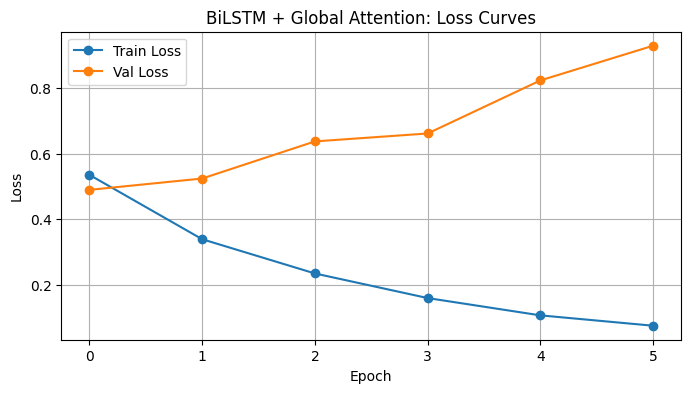

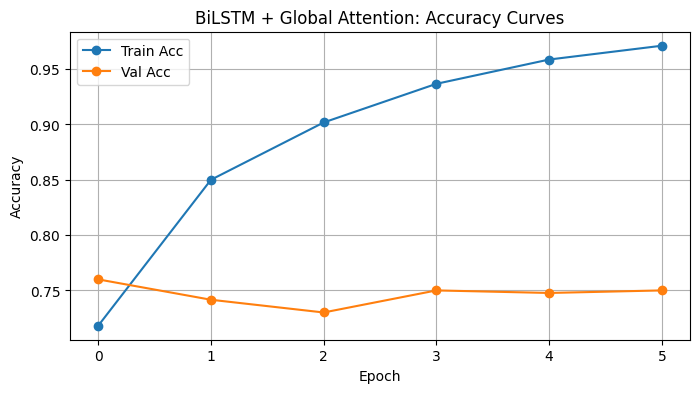

In [45]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.legend(); plt.title("BiLSTM + Global Attention: Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Acc", marker="o")
plt.plot(val_accs, label="Val Acc", marker="o")
plt.legend(); plt.title("BiLSTM + Global Attention: Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.show()

### Model Evaluation


Validation Report:
              precision    recall  f1-score   support

     neutral       0.73      0.78      0.76       647
     entails       0.77      0.72      0.74       657

    accuracy                           0.75      1304
   macro avg       0.75      0.75      0.75      1304
weighted avg       0.75      0.75      0.75      1304


Test Report:
              precision    recall  f1-score   support

     neutral       0.75      0.79      0.77      1284
     entails       0.65      0.61      0.63       842

    accuracy                           0.71      2126
   macro avg       0.70      0.70      0.70      2126
weighted avg       0.71      0.71      0.71      2126



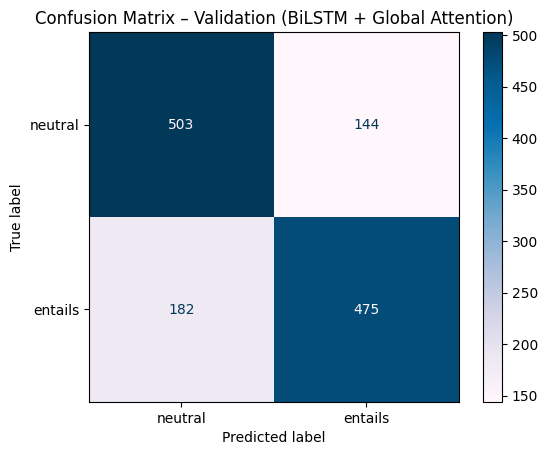

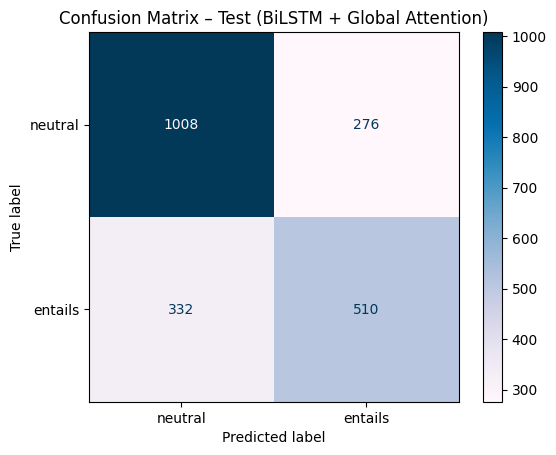

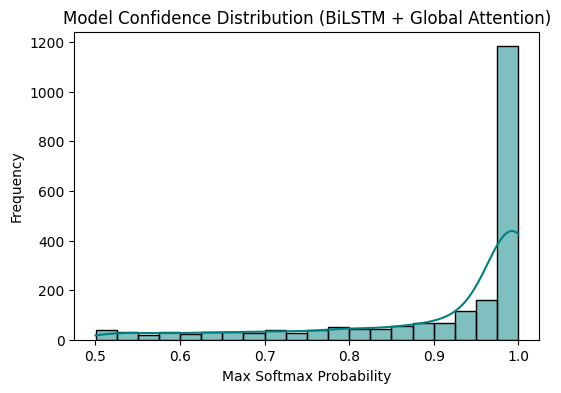

In [47]:
def evaluate_model(model, loader):
    model.eval(); preds, labels_all, probs = [], [], []
    with torch.no_grad():
        for prem, hyp, lbl in loader:
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model(prem, hyp)
            prob = F.softmax(logits, dim=1)
            preds.extend(torch.argmax(prob, dim=1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())
            probs.extend(prob.max(dim=1)[0].cpu().numpy())
    return preds, labels_all, probs

val_preds, val_labels, val_probs = evaluate_model(model2, val_loader)
test_preds, test_labels, test_probs = evaluate_model(model2, test_loader)

print("\nValidation Report:")
print(classification_report(val_labels, val_preds, target_names=["neutral","entails"]))
print("\nTest Report:")
print(classification_report(test_labels, test_preds, target_names=["neutral","entails"]))

for split, labels, preds in [("Validation", val_labels, val_preds), ("Test", test_labels, test_preds)]:
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral","entails"])
    disp.plot(cmap="PuBu", values_format="d")
    plt.title(f"Confusion Matrix – {split} (BiLSTM + Global Attention)")
    plt.show()

# --- Confidence Histogram ---
plt.figure(figsize=(6,4))
sns.histplot(test_probs, bins=20, kde=True, color="teal")
plt.title("Model Confidence Distribution (BiLSTM + Global Attention)")
plt.xlabel("Max Softmax Probability"); plt.ylabel("Frequency")
plt.show()

### Visualising attention

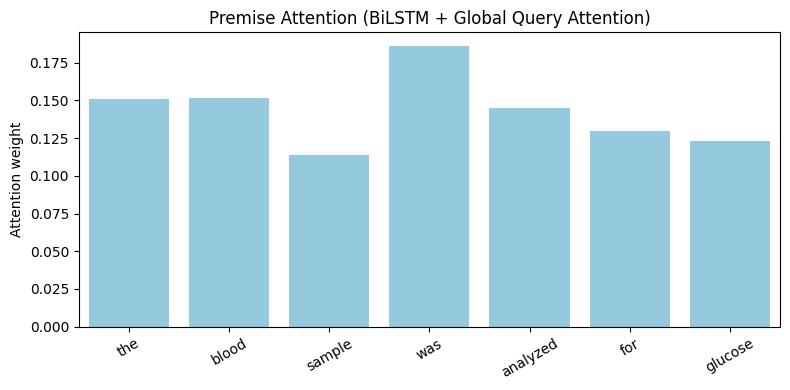

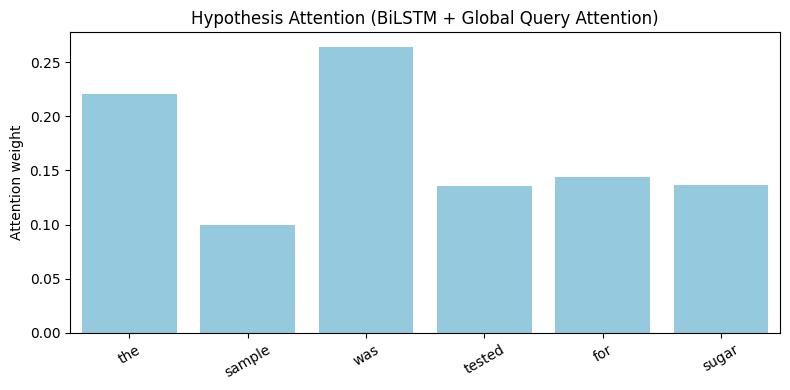

In [48]:
def visualize_attention(model, sentence, vocab, title="Attention Heatmap"):
    model.eval()
    tokens = re.sub(r"[^a-z0-9\s]", "", sentence.lower()).split()
    ids = torch.tensor([[vocab.get(tok, vocab["<unk>"]) for tok in tokens]]).to(DEVICE)
    with torch.no_grad():
        H, _ = model.bilstm(model.embedding(ids))
        _, weights = model.attn(H)
    plt.figure(figsize=(8,4))
    sns.barplot(x=tokens, y=weights.squeeze(0).cpu().numpy(), color="skyblue")
    plt.title(title); plt.ylabel("Attention weight"); plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()

visualize_attention(model2, "the blood sample was analyzed for glucose", vocab,
                    "Premise Attention (BiLSTM + Global Query Attention)")
visualize_attention(model2, "the sample was tested for sugar", vocab,
                    "Hypothesis Attention (BiLSTM + Global Query Attention)")

## Export

In [49]:
best_path = "models/bilstm_globalattn_best.pt"
zip_path  = "models/bilstm_globalattn_best.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(best_path, arcname=os.path.basename(best_path))
print(f"Best model zipped and ready for download → {zip_path}")

from google.colab import files
files.download(zip_path)

FileNotFoundError: [Errno 2] No such file or directory: 'models/bilstm_globalattn_best.zip'

# Transformer Architechture Inspiration
NLI tasks are generally done using just the encoder only transformer architechture model which can help us to do classification task like classifying the Hypothesis and premise as `entails` or `nuetral`

We can skip the decoder model to perform NLI task as we are not generating new stream of the text.

Our inspiration to begin with such encoder model was from the transformer model architechture based on the "Attention is all you need" paper

### NLI Task Setup

We can follow BERT STYLE for our input  
```
[CLS] Premise [SEP] Hypothesis [SEP]
↓
Encoder (BERT)
↓
[CLS] → Classification head → Entail / Contradict / Neutral
```

or T5-style (Encoder-decoder style)
```
Input: "mnli premise: <text1> hypothesis: <text2>"
Output: "entailment"
```

# Transformer Architecture
- Built on encoder - decoder model
- Built entirely on self attention + feed forward network layers (No Recurrence and convolution)

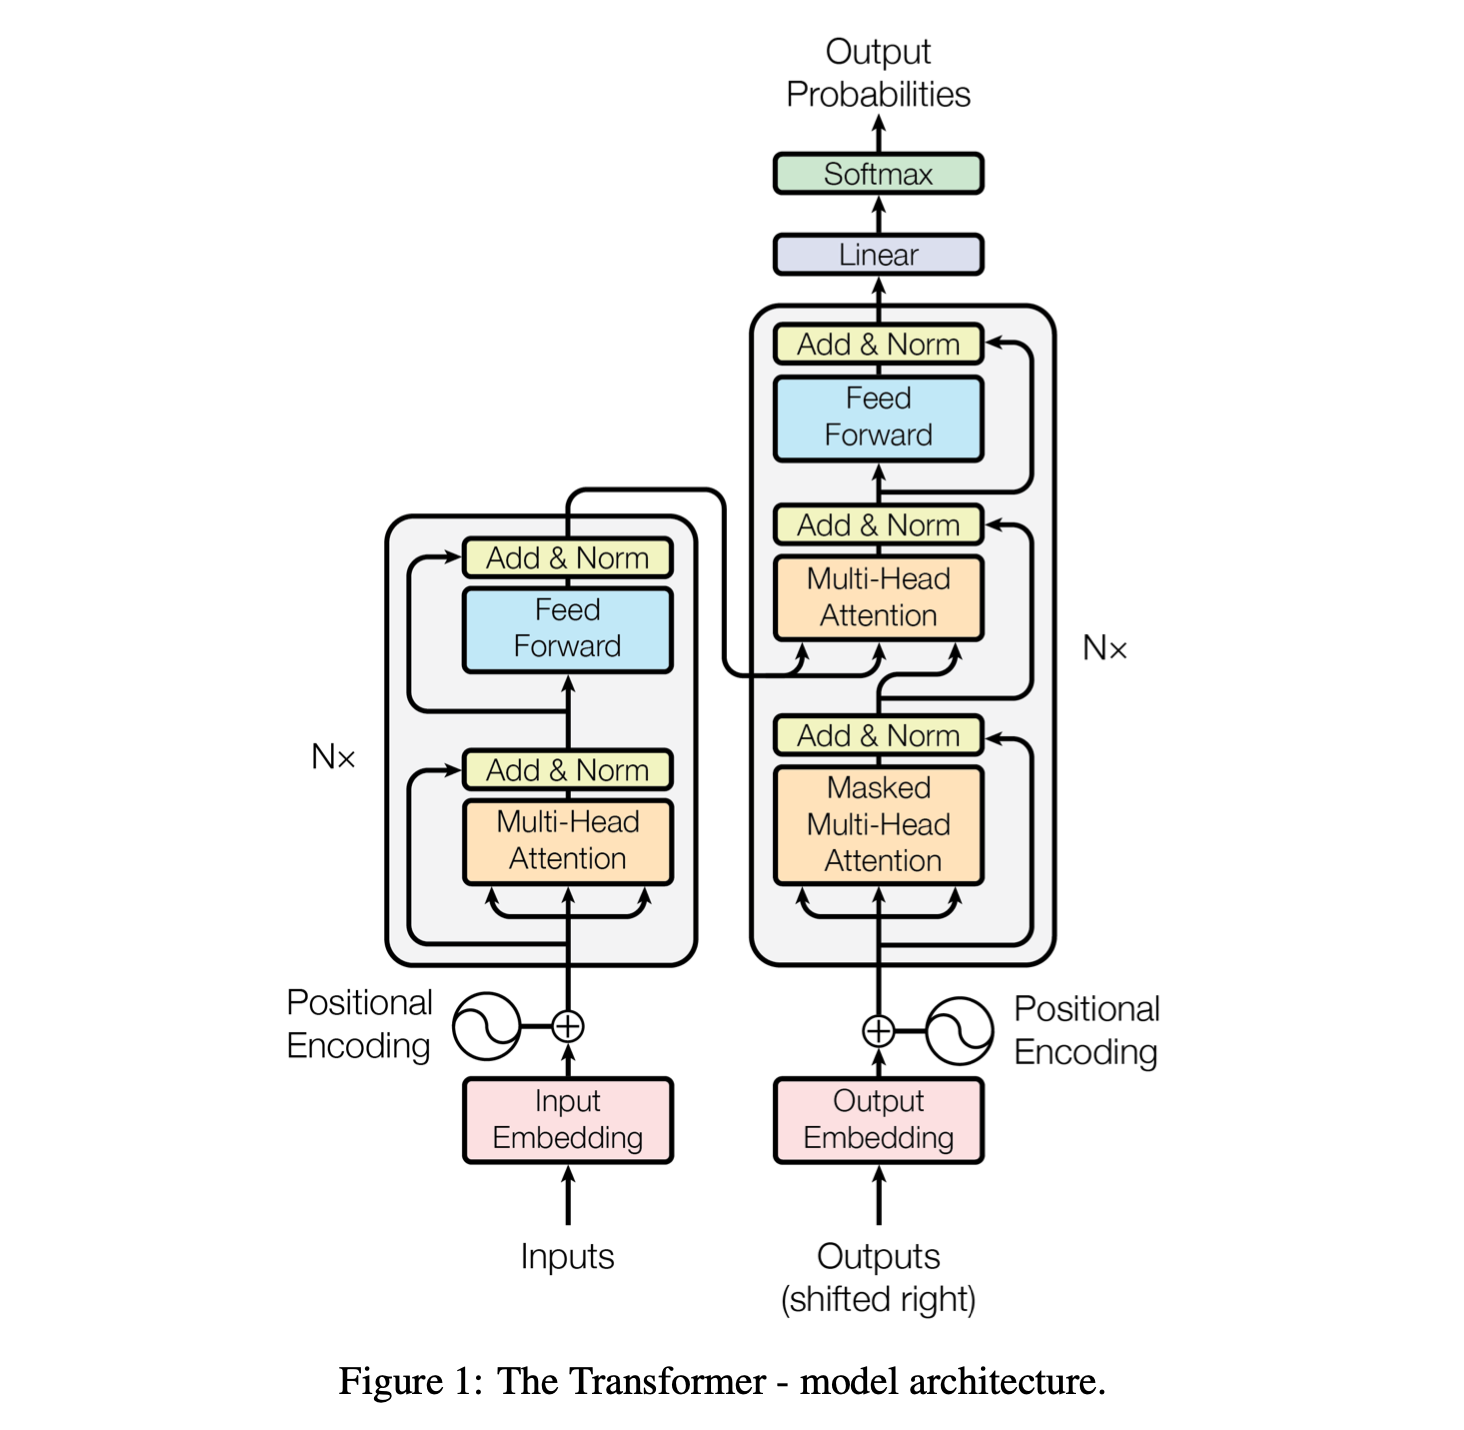

Understanding the transformer architechture
### Encoder (N times)
1. Input Embedding
2. Positional Encoding
3. MultiHead Attention + Add & Norm
4. Feed Forward + Add & Norm

### Decoder (N times)
1. Output Encoding
2. Positional Encoding
3. *Masked* MultiHead Attention + Add & Norm
4. Cross MultiHead Attention (Learnings from Encoder are embedded) + Add & Norm
5. Feed Forward + Add & Norm

### Output
1. Linear
2. Softmax

Since we are focusing on the encoder only transformer architechture we will be skipping out on the decoder part of the architechture


Encoder vs Decoder vs Full Transformer  
| Component| Core Idea | Used For | How it changes in NLI |
| ----- | ---- | ----- | ----- |
| Encoder only | Bidirectional attention sees full context | classification, sentence similarity | Best choice: can compare both texts directly |
| Decoder Only | Causal (left to right) | generation chat or reasoning | can be prompted for NLI but not trained specifically |
| Encoder-Decoder Only | Encoder reads input, decoder generates output | seq2seq (translation, summarisation) | Overhead unless you frame NLI as generation |  

Eg of different arch
- Encoder: BERT
- Decoder: GPT
- Encoder-decoder: T5/BERT

# Implementing components for Transformers

## Building Positional Encoding Module
Since transformer doesn't have idea about the previous sequence of knowledge and we need a way to embed the positional information about the data. So transformer paper suggest using of the Periodic functions which can help us out in maintaining the positional information while training.

Referrence: "Attention is all you need"

$$
\mathrm{PE}_{(pos,\,2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_\text{model}}}}\right)
$$

$$
\mathrm{PE}_{(pos,\,2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_\text{model}}}}\right)
$$

- pos: position of the token in the sequence (0, 1, 2, …)
- i: dimension index (0, 1, 2, …)
- d_{model}: the total embedding dimension (e.g., 512)
- 2i and 2i+1 split sine and cosine across even and odd indices

Basically we are using two formula based on the token's position. If the token is even or odd and then we use either cos or sin

In [ ]:
class Sinusoidal_Positional_Encoding(nn.Module):
    """
    d_model: Embedding dimension which is same as the input embedding dimension
    max_seq_len: the maximum length of the input sequence
    """
    def __init__(self, d_model: int, max_seq_len: int = 1000):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        # Positional Encoding Matrix
        pe = torch.zeros(max_seq_len, d_model)    # creating a zero matrix of shape of the maximum sequence length and the embedding dimension
        position = torch.arrange(0, max_seq_len, dtype=torch.float).unsqueeze(1)     # creating a position matrix of shape of the maximum sequence length
        div_term = torch.exp(torch.arrange(0, d_model, 2).float() * -(math.log(10000)/ d_model))
        pe[:, 0::2] = torch.sin(position * div_term)        # for even index
        pe[:, 1::2] = torch.cos(position * div_term)        # for odd index
        self.register_buffer("pe", pe)  # this is a buffer which becomes a parameter of the model without gradients

## Single Head Self Attention

### Masking
Masking is present in the multi head attention module present in decoder part of the transformer model.
This helps the model to avoid using the next tokens in the sequence for training

In [ ]:
def casual_mask(T: int, device: torch.device)->torch.Tensor:
    """
    Returns a bool mask where True means *masked*
    """

    m = torch.triu(torch.ones(T, T, device=device), diagonal=1)
    return m.view(1,1,T,T)

### Attention
Referrence "Attention is all you need"

Here the attention head created is based on the scaled dot-product attention formula presented in the transformers paper  
**Scaled Dot-Product Attention Formula** : The scaled dot-product attention computes attention scores as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V
$$

where:
- \( Q \) = queries,
- \( K \) = keys,
- \( V \) = values,
- \( d_k \) = dimensionality of keys.


> Insert the Attention Image here

We are implementing the Scaled Dot Product (Left Diagram)

In [ ]:
class Single_Head_Self_Attention(nn.Module):
    """
    Single-Head Attention
    args:
        d_model: embedding dimension
        d_k: dimension of the key, value and
        dropout: dropout rate
        trace_shapes: whether to trace the shapes of the tensors for debugging
    """
    def __init__(self, d_model: int, d_k: int, dropout: float = 0.0, causal: bool = True, trace_shapes: bool = False):
        super().__init__()
        self.d_k = d_k  # Store d_k as instance variable for use in forward
        self.q = nn.Linear(d_model, d_k, bias=False)
        self.k = nn.Linear(d_model, d_k, bias=False)
        self.v = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.causal = causal
        self.trace_shapes = trace_shapes

    def forward(self, x: torch.Tensor):  # (B, T, d_model)
        batch_size, seq_len, _ = x.shape
        q = self.q(x)    # (Batch_size, Seq_len, d_k)
        k = self.k(x)    # (Batch_size, Seq_len, d_k)
        v = self.v(x)    # (Batch_size, Seq_len, d_k)
        if self.trace_shapes:
            print(f"q: {tuple(q.shape)}")
            print(f"k: {tuple(k.shape)}")
            print(f"v: {tuple(v.shape)}")

        # Applying the scaled dot-product attention formula
        scale = 1.0 / math.sqrt(self.d_k)
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale   # (Batch_size, Seq_len, Seq_len)

        # Masking the upper triangle of the attention matrix
        # Why? To prevent the model from attending to future tokens during training
        if self.causal:
            mask = casual_mask(seq_len, device=x.device)
            attention = attention.masked_fill(mask.squeeze(1), float("-inf"))
        w = F.softmax(attention, dim=-1)
        w = self.dropout(w)
        out = torch.matmul(w, v)   # (Batch_size, Seq_len, d_k)
        if self.trace_shapes:
            print(f"Weights: {tuple(w.shape)} Out {out.shape}")
        return out, w


## Building multi head attention module

> Attach the attention image here

We are now implementing the Multiple Scaled Dot Product which are stacked (Right Diagram)

In [ ]:
class Multi_Head_Self_Attention(nn.Module):
    """
    Multi-Head Attention
    This represent one multi head self attention block

    args:
        d_model: embedding dimension
        n_heads: number of attention heads
        dropout: dropout rate
        trace_shapes: whether to trace the shapes of the tensors for debugging

    note:
        d_k (d_head here) ie, dimension of the key, value and query is same as d_model / n_heads
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.0, causal: bool = True, trace_shapes: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.causal = causal
        self.trace_shapes = trace_shapes

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)      # we need to project the input to 3 times the dimension of the input so that we can split it into query, key and value
        self.proj = nn.Linear(d_model, d_model, bias=False)         # after the attention computation, we need to project the output back to the original dimension


    def forward(self, x: torch.Tensor):
        batch_size, seq_len, C = x.shape   # c is the embedding dimension
        qkv = self.qkv(x)
        qkv = qkv.view(batch_size, seq_len, 3, self.n_heads, self.d_head)
        q, k, v = qkv.unbind(dim=2)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        if self.trace_shapes:
            print(f"q: {tuple(q.shape)}")
            print(f"k: {tuple(k.shape)}")
            print(f"v: {tuple(v.shape)}")

        scale = 1.0 / math.sqrt(self.d_head)
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale

        # mask out the upper triangle of the attention matrix
        if self.causal:
            mask = casual_mask(seq_len, device=x.device)
            attention = attention.masked_fill(mask, float("-inf"))

        w = F.softmax(attention, dim=-1)
        w = self.dropout(w)
        ctx = torch.matmul(w, v)
        if self.trace_shapes:
            print(f"ctx: {tuple(ctx.shape)}")
        ctx = ctx.transpose(1, 2)
        # we need to make sure that the context is contiguous
        # because the view operation is not guaranteed to be contiguous
        # if it is not contiguous, the view operation will throw an error
        # contiguous means that the memory is in a contiguous block
        ctx = ctx.contiguous().view(batch_size, seq_len, C)
        out = self.proj(ctx)
        return out


# Building Cross Attention

## Cross-Attention for Decoder

Cross-attention is a key component of the transformer decoder. Unlike self-attention where queries, keys, and values all come from the same sequence, in cross-attention:
- **Queries (Q)**: Come from the decoder (target sequence)
- **Keys (K) and Values (V)**: Come from the encoder (source sequence)

This allows the decoder to attend to the encoder's representations while generating the target sequence.


In [ ]:
class CrossAttention(nn.Module):
    """
    Cross-Attention mechanism for transformer decoder.

    In cross-attention:
    - Queries come from decoder (target sequence)
    - Keys and Values come from encoder (source sequence)

    Args:
        d_model: embedding dimension
        n_heads: number of attention heads
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """

    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.0, trace_shapes: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.trace_shapes = trace_shapes

        # Separate projections for queries (from decoder) and keys/values (from encoder)
        self.q_proj = nn.Linear(d_model, d_model, bias=False)  # Queries from decoder
        self.kv_proj = nn.Linear(d_model, 2 * d_model, bias=False)  # Keys and Values from encoder
        self.out_proj = nn.Linear(d_model, d_model, bias=False)  # Output projection

    def forward(self, decoder_hidden: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            decoder_hidden: decoder representations (B, tgt_len, d_model)
            encoder_output: encoder representations (B, src_len, d_model)
            src_mask: source padding mask (B, src_len) - True for padding positions
        Returns:
            output: cross-attended representations (B, tgt_len, d_model)
        """
        B, tgt_len, _ = decoder_hidden.shape
        B, src_len, _ = encoder_output.shape

        # Generate queries from decoder hidden states
        q = self.q_proj(decoder_hidden)  # (B, tgt_len, d_model)

        # Generate keys and values from encoder output
        kv = self.kv_proj(encoder_output)  # (B, src_len, 2 * d_model)

        # Reshape for multi-head attention
        q = q.view(B, tgt_len, self.n_heads, self.d_head).transpose(1, 2)  # (B, n_heads, tgt_len, d_head)
        kv = kv.view(B, src_len, 2, self.n_heads, self.d_head)
        k, v = kv.unbind(dim=2)  # Each: (B, src_len, n_heads, d_head)
        k = k.transpose(1, 2)  # (B, n_heads, src_len, d_head)
        v = v.transpose(1, 2)  # (B, n_heads, src_len, d_head)

        if self.trace_shapes:
            print(f"Cross-attention - q: {tuple(q.shape)}, k: {tuple(k.shape)}, v: {tuple(v.shape)}")

        # Scaled dot-product attention
        scale = 1.0 / math.sqrt(self.d_head)
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, n_heads, tgt_len, src_len)

        # Apply source mask if provided (mask out padding tokens in source)
        if src_mask is not None:
            # Expand mask for multi-head attention: (B, 1, 1, src_len)
            src_mask = src_mask.unsqueeze(1).unsqueeze(2)
            attention_scores = attention_scores.masked_fill(src_mask, float('-inf'))

        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        context = torch.matmul(attention_weights, v)  # (B, n_heads, tgt_len, d_head)

        if self.trace_shapes:
            print(f"Cross-attention context: {tuple(context.shape)}")

        # Concatenate heads and project
        context = context.transpose(1, 2).contiguous().view(B, tgt_len, self.d_model)
        output = self.out_proj(context)

        return output


## Feedforward

In [ ]:
## Building simple feed forward network with GELU activation
class FeedForward(nn.Module):
    """
    Position-wise Feed Forward Network

    Args:
        d_model: input/output dimension
        d_hd : hidden dimension
        dropout: dropout rate
    """

    def __init__(self, d_model: int, d_hd: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_hd)
        self.linear2 = nn.Linear(d_hd, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """
        x : (Batch_size, Seq_len, d_model)
        returns : (Batch_size, Seq_len, d_model)
        """
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

## Building Layer normalization
mean of all features
$$
\mu = \frac{1}{D} \sum_{i=1}^{D} x_i, \quad
$$

variabce of all features
$$
\sigma^2 = \frac{1}{D} \sum_{i=1}^{D} (x_i - \mu)^2
$$

$$
\text{LayerNorm}(x_i) = \gamma \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

In [ ]:
class LayerNorm(nn.Module):
    """
    Layer Normalization

    Args:
        d_model : dimension to normalize over
        eps : using small value to avoid division by zero
        bias : boolean to include bias or not
    """

    def __init__(self, d_model: int, eps: float = 1e-5, bias: bool = True):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model)) if bias else None

    def forward(self, x: torch.Tensor):
        """
        x : (Batch_size, Seq_len, d_model)
        returns : (Batch_size, Seq_len, d_model)
        """
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized = (x - mean) / torch.sqrt(var + self.eps)
        normalized = normalized * self.weight
        if self.bias is not None:
            normalized = normalized + self.bias
        return normalized



we can use nn.LayerNormalization from pytorch to implement the layernormalization directly

In [ ]:
# LayerNorm = nn.LayerNorm(d_model, eps=1e-5, elementwise_affine=True)
# elementwise_affine = True means that the layer normalization will have learnable parameters ie, weights and biases
# if we set it to False, the layer normalization will not have any learnable parameters and it will be a simple layer normalization

In [ ]:
class Residual_Connection(nn.Module):
    """
    Residual connection with layer normalization.
    It supports both pre normalization and post normalization
    """
    def __init__(self, d_model: int, dropout: float = 0.1, bias: bool = True, pre_norm: bool = True):
        super().__init__()
        self.norm = nn.LayerNorm(d_model, eps=1e-5, elementwise_affine=bias)
        self.dropout = nn.Dropout(dropout)
        self.pre_norm = pre_norm

    def forward(self, x, sublayer) -> torch.Tensor:
        """
        Apply residual connection to any sublayer with the same size

        Args:
            x: input tensor (batch_size, seq_len, d_model)
            sublayer: function that takes x and returns tensor of same shape
        Returns:
            output: (batch_size, seq_len, d_model)
        """
        if self.pre_norm:
            return x + self.dropout(sublayer(self.norm(x)))
        else:
            return self.norm(x + self.dropout(sublayer(x)))


In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    This is a convenience wrapper that combines residual connection and layer norm.
    """
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer) -> torch.Tensor:
        return x + self.dropout(sublayer(self.norm(x)))


# Encoder Flow
```
Input: x (batch_size, seq_len, d_model)
    ↓
1. Attention + Residual:
   x = x + dropout(self_attention(layer_norm(x)))
    ↓  
2. Feed Forward + Residual:
   x = x + dropout(feed_forward(layer_norm(x)))
    ↓
Output: x (batch_size, seq_len, d_model)
```

## Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """
    A single transformer encoder block

    Args:
        d_model: model dimension
        n_heads: number of attention heads
        d_ff: feed forward hidden dimension
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, trace_shapes: bool = False):
        super().__init__()
        self.d_model = d_model
        self.trace_shapes = trace_shapes

        self.self_attention = Multi_Head_Self_Attention(
            d_model=d_model,
            n_heads=n_heads,
            dropout=dropout,
            trace_shapes=trace_shapes,
            causal=False
        )

        self.feed_forward = FeedForward(
            d_model = d_model,
            d_ff = d_ff,
            dropout = dropout
        )

        self.sublayer1 = SublayerConnection(d_model, dropout)
        self.sublayer2 = SublayerConnection(d_model, dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the encoder block

        Args:
            x: input tensor (batch_size, seq_len, d_model)
            mask: attention_mask (batch_size, seq_len) - True for positions to mask

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        if self.trace_shapes:
            print(f"EncoderBlock input: {tuple(x.shape)}")

        # Self-attention with residual connection
        x = self.sublayer1(x, lambda x: self.self_attention(x))
        if self.trace_shapes:
            print(f"After self-attention: {tuple(x.shape)}")

        # Feed forward with residual connection
        x = self.sublayer2(x, lambda x: self.feed_forward(x))

        if self.trace_shapes:
            print(f"EncoderBlock output: {tuple(x.shape)}")

        return x

## Stacked Encoder Block

In [ ]:
class StackedEncoderBlocks(nn.Module):
    """
    Stack of N transformer encoder blocks.

    Args:
        n_layers: number of encoder blocks
        d_model: model dimension
        n_heads: number of attention heads
        d_ff: feed forward hidden dimension
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """

    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, trace_shapes: bool = False):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(
                d_model=d_model,
                n_heads=n_heads,
                d_ff=d_ff,
                dropout=dropout,
                trace_shapes=trace_shapes
            )
            for _ in range(n_layers)
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the stacked encoder blocks
        mask: attention mask (batch_size, seq_len) - True for positions to mask

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, mask)
        return x

## Ablation study

### Based on the positional Encoding

In [ ]:
# For ablation study, we can use the learned positional encoding as well
class Learned_Positional_Encoding(nn.Module):
    """
    d_model: Embedding dimension
    max_seq_len: the maximum length of the input sequence
    """
    def __init__(self, d_model: int, max_seq_len: int = 1000):
        super().__init__()
        self.embeddding = nn.Embedding(max_seq_len, d_model)

    def forward(self, x: torch.Tensor)->torch.Tensor:
        """
        x(input): (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.size()
        pos = torch.arrange(seq_len, device=x.device).unsqueeze(0)
        pos_emb = self.embeddding(pos)
        return x + pos_emb.unsqueeze(0)

### Based on masking

In [ ]:
# for ablation study, we can use the no_mask as well
def no_mask(T: int, device: torch.device)->torch.Tensor:
    return torch.zeros(1, 1, T, T, dtype=torch.bool, device=device)

no mask should cause data leakage but can be used as our baseline

In [ ]:
def random_mask(T: int, device: torch.device, mask_prob: float = 0.15)->torch.Tensor:
    mask = torch.rand(1,1,T,T, device=device) < mask_prob
    return mask

Testing how our model handles random occlusion. Can be useful when exploring the robustness or masked language modelling
Can simulate missing information

## Based on adding decoder into the model
trying to get the NLI Task executed with encoder-decoder architechture